# 1. GBDT回归树原理

## 1.1 创建数据

In [1]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz

In [2]:
### 实际问题，年龄预测，回归问题
# 简单的数据，算法原理，无论简单数据，还是复杂数据，都一样

# 属性一表示花销，属性二表示上网时间
X = np.array([[600,0.8],[800,1.2],[1500,10],[2500,3]])

y = np.array([14,16,24,26]) # 年龄：高一、高三，大四，工作两年

# loss  = ls 最小二乘法
learning_rate = 0.1
gbdt = GradientBoostingRegressor(n_estimators=3,  # 才设置了 3 棵树，所以和真实值还是有差距
                                 # loss = 'ls',  # 最小二乘法
                                 loss = 'squared_error', # 现在版本中应该是 squared_error
                                 learning_rate=0.1) # learning_rate 学习率
gbdt.fit(X,y)#训练
y_ = gbdt.predict(X)#预测
y_

array([18.374, 18.916, 21.084, 21.626])

## 1.2 可视化

In [3]:
# 第一颗树，分叉时，friedman-mse (就是均方误差)= 26
print('均方误差：',((y - y.mean())**2).mean())
dot_data = tree.export_graphviz(gbdt[0,0],filled=True)
graph = graphviz.Source(dot_data)
graph.render('./第一棵树',format='png')

均方误差： 26.0


'第一棵树.png'

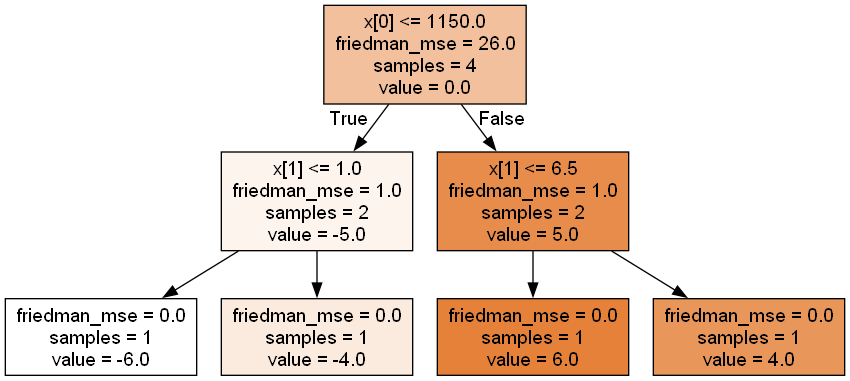

In [4]:
# 第二颗树
dot_data = tree.export_graphviz(gbdt[1,0],filled=True)
graph = graphviz.Source(dot_data)
graph = graphviz.Source(dot_data)
graph.render('./第二棵树',format='png')

'第二棵树.png'

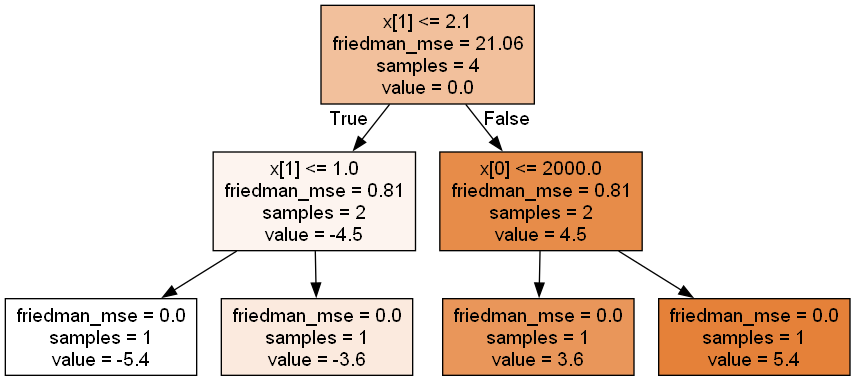

In [5]:
# 第三颗树
dot_data = tree.export_graphviz(gbdt[2,0],filled=True)
graph = graphviz.Source(dot_data)
graph.render('./第三棵树',format='png')

'第三棵树.png'

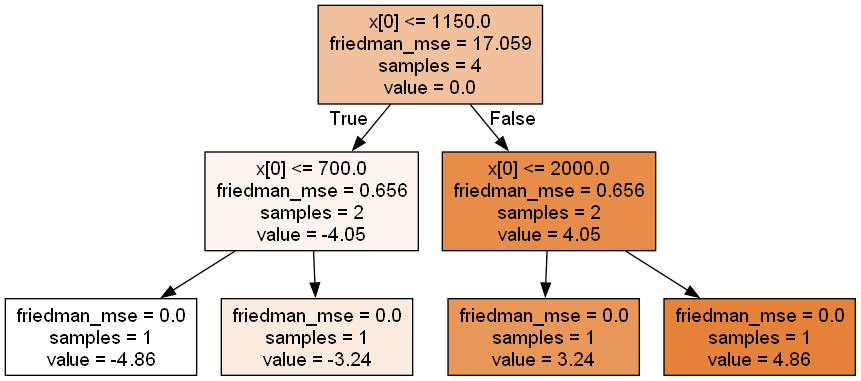

## 1.3 每棵树结构关系

In [6]:
print(y)

[14 16 24 26]


In [7]:
print(y.mean())

20.0


In [8]:
# 初始第一棵树的残差
# y.mean() 就是回归树的初始值！！！（对比梯度提升分类树的初始值）
residual0 = y - y.mean()
residual0

array([-6., -4.,  4.,  6.])

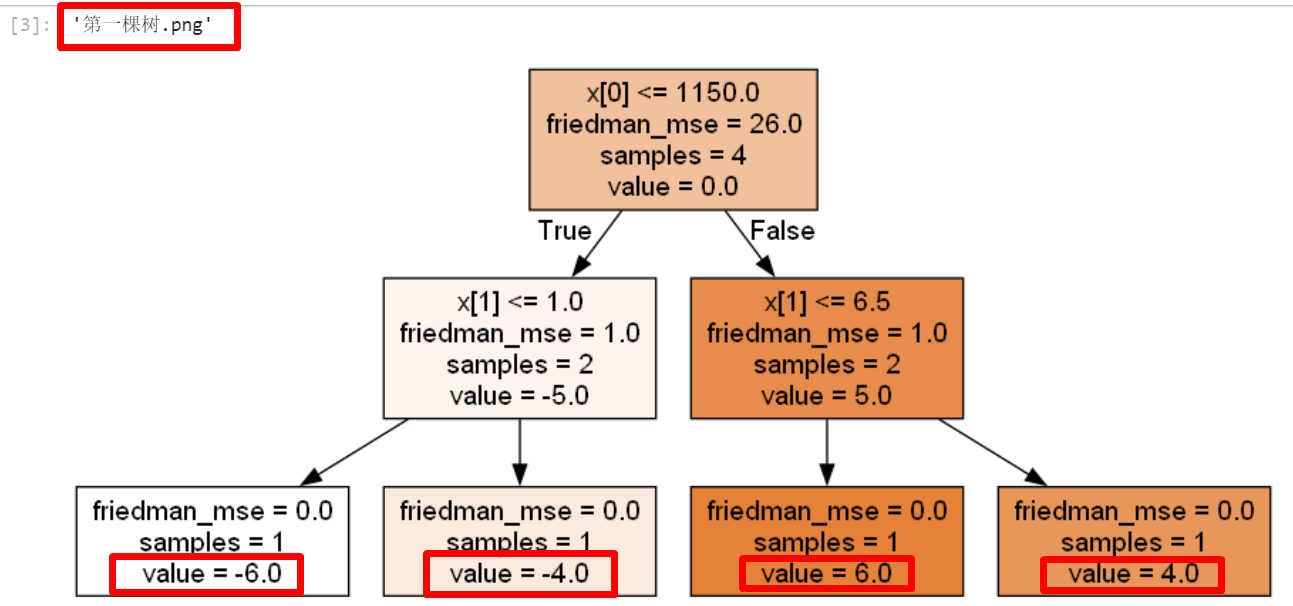

In [9]:
# 梯度提升树，第二棵树
residual1 = residual0 - learning_rate * residual0
residual1

array([-5.4, -3.6,  3.6,  5.4])

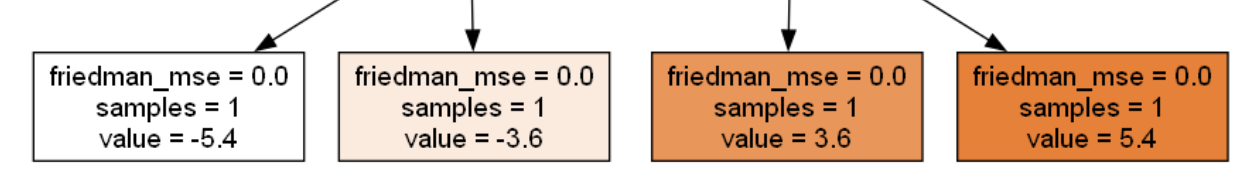

In [10]:
# 梯度提升树，第三棵树
residual2 = residual1 - learning_rate * residual1
residual2

array([-4.86, -3.24,  3.24,  4.86])

In [52]:
# 第三棵树，就是最后一棵树
# 最后一棵树，提升
residual3 = residual2 - residual2 * learning_rate
residual3 # 残差！！！

array([-4.374, -2.916,  2.916,  4.374])

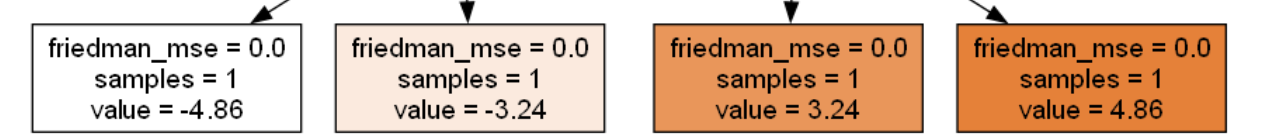

In [11]:
gbdt.predict(X)  # 算法建模预测的结果

array([18.374, 18.916, 21.084, 21.626])

In [54]:
predict = y - residual3  # 根据每一棵树的叶节点的value，梯度下降计算而来
predict

array([18.374, 18.916, 21.084, 21.626])

## 1.4 最佳裂分条件计算

### 1.4.1 第一棵树裂分

In [12]:
# 计算未分裂均方误差
lower_mse = ((y - y.mean())**2).mean()
print('未分裂均方误差是：',lower_mse)
best_split = {}
for index in range(2): # 特征
    for i in range(3):# 样本数量
        t = X[:,index].copy()
        t.sort()
        split = t[i:i + 2].mean()
        cond = X[:,index] <= split
        mse1 = round(((y[cond] - y[cond].mean())**2).mean(),3)
        mse2 = round(((y[~cond] - y[~cond].mean())**2).mean(),3)
        p1 = cond.sum()/cond.size
        mse = round(mse1 * p1 + mse2 * (1- p1),3)
        print('第%d列' % (index),'裂分条件是：',split,'均方误差是：',mse1,mse2,mse)
        if mse < lower_mse:
            best_split.clear()
            lower_mse = mse
            best_split['第%d列'%(index)] = split
        elif mse == lower_mse:
            best_split['第%d列'%(index)] = split
print('最佳分裂条件是：',best_split)

未分裂均方误差是： 26.0
第0列 裂分条件是： 700.0 均方误差是： 0.0 18.667 14.0
第0列 裂分条件是： 1150.0 均方误差是： 1.0 1.0 1.0
第0列 裂分条件是： 2000.0 均方误差是： 18.667 0.0 14.0
第1列 裂分条件是： 1.0 均方误差是： 0.0 18.667 14.0
第1列 裂分条件是： 2.1 均方误差是： 1.0 1.0 1.0
第1列 裂分条件是： 6.5 均方误差是： 27.556 0.0 20.667
最佳分裂条件是： {'第0列': 1150.0, '第1列': 2.1}


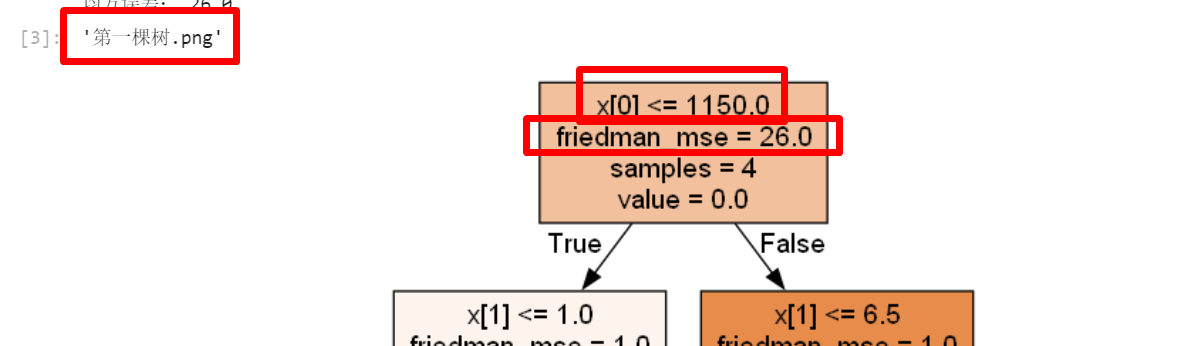

### 1.4.2 第二棵树

In [13]:
residual = y - y.mean()
residual

array([-6., -4.,  4.,  6.])

In [14]:
# 梯度下降，降低残差
residual = residual - learning_rate*residual

In [58]:
# 计算未分裂均方误差
lower_mse = round(((residual - residual.mean())**2).mean(),3)
print('未分裂均方误差是：',lower_mse)
best_split = {}
for index in range(2):
    for i in range(3):
        t = X[:,index].copy()
        t.sort()
        split = t[i:i + 2].mean()
        cond = X[:,index] <= split
        mse1 = round(((residual[cond] - residual[cond].mean())**2).mean(),3)
        mse2 = round(((residual[~cond] - residual[~cond].mean())**2).mean(),3)
        p1 = cond.sum()/cond.size
        mse = round(mse1 * p1 + mse2 * (1- p1),3)
        print('第%d列' % (index),'裂分条件是：',split,'均方误差是：',mse1,mse2,mse)
        if mse < lower_mse:
            best_split.clear()
            lower_mse = mse
            best_split['第%d列'%(index)] = split
        elif mse == lower_mse:
            best_split['第%d列'%(index)] = split
print('最佳分裂条件是：',best_split)

未分裂均方误差是： 21.06
第0列 裂分条件是： 700.0 均方误差是： 0.0 15.12 11.34
第0列 裂分条件是： 1150.0 均方误差是： 0.81 0.81 0.81
第0列 裂分条件是： 2000.0 均方误差是： 15.12 0.0 11.34
第1列 裂分条件是： 1.0 均方误差是： 0.0 15.12 11.34
第1列 裂分条件是： 2.1 均方误差是： 0.81 0.81 0.81
第1列 裂分条件是： 6.5 均方误差是： 22.32 0.0 16.74
最佳分裂条件是： {'第0列': 1150.0, '第1列': 2.1}


### 1.4.3 第三棵树最接裂分计算

In [15]:
# 梯度下降，降低残差
residual = residual - learning_rate*residual
# 计算未分裂均方误差
lower_mse = round(((residual - residual.mean())**2).mean(),3)
print('未分裂均方误差是：',lower_mse)
best_split = {}
for index in range(2):
    for i in range(3):
        t = X[:,index].copy()
        t.sort()
        split = t[i:i + 2].mean()
        cond = X[:,index] <= split
        mse1 = round(((residual[cond] - residual[cond].mean())**2).mean(),3)
        mse2 = round(((residual[~cond] - residual[~cond].mean())**2).mean(),3)
        p1 = cond.sum()/cond.size
        mse = round(mse1 * p1 + mse2 * (1- p1),3)
        print('第%d列' % (index),'裂分条件是：',split,'均方误差是：',mse1,mse2,mse)
        if mse < lower_mse:
            best_split.clear()
            lower_mse = mse
            best_split['第%d列'%(index)] = split
        elif mse == lower_mse:
            best_split['第%d列'%(index)] = split
print('最佳分裂条件是：',best_split)

未分裂均方误差是： 17.059
第0列 裂分条件是： 700.0 均方误差是： 0.0 12.247 9.185
第0列 裂分条件是： 1150.0 均方误差是： 0.656 0.656 0.656
第0列 裂分条件是： 2000.0 均方误差是： 12.247 0.0 9.185
第1列 裂分条件是： 1.0 均方误差是： 0.0 12.247 9.185
第1列 裂分条件是： 2.1 均方误差是： 0.656 0.656 0.656
第1列 裂分条件是： 6.5 均方误差是： 18.079 0.0 13.559
最佳分裂条件是： {'第0列': 1150.0, '第1列': 2.1}


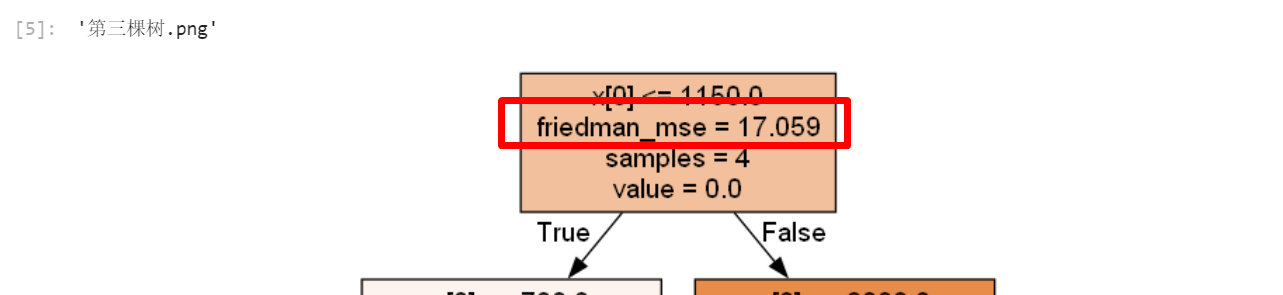